In [4]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import json

# Importing data

In [5]:
output_variables = ['T2','T24','T30','T50','P2','P15','P30','Nf','Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']
column_names = ['id','cycle']
n_op = 3
n_sensors = 21
features = ['o'+str(n) for n in range(1,n_op+1)]+['s'+str(n) for n in range(1,n_sensors+1)]
column_names.extend(features)
train_files = [f'train_FD00{i}.txt' for i in range(1,5)]

train_dfs = []
for train_file in train_files:    
    train_dfs.append(pd.read_csv(f'data/{train_file}',header=None,sep='\s+',names=column_names))

In [6]:
### Selecting the dataframe used ###
n = 0
train_df = train_dfs[n]
train_df

,id,cycle,o1,o2,o3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


# Dropping Sensors with low variance

In [7]:
train_df = train_df[train_df.columns[train_df.var() > 1e-10]]
low_variance_features = set(features)-set(train_df.columns)
features = list(set(features).intersection(set(train_df.columns)))
print(f"Dropped low variance sensors: {low_variance_features}")

Dropped low variance sensors: {'s5', 's18', 's1', 's16', 'o3', 's10', 's19'}


# Z-normalizing

In [8]:
means = train_df[features].mean()
with open('means.json', 'w', encoding ='utf8') as means_file:
    json.dump(means.to_dict(), means_file)

stds = train_df[features].std()
with open('stds.json', 'w', encoding ='utf8') as stds_file:
    json.dump(stds.to_dict(), stds_file)

# Saving means and stds for standardization of the test set   
norm_train_df = train_df.copy()
norm_train_df[features] = (norm_train_df[features]-means)/stds
norm_train_df

,id,cycle,o1,o2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21
0,1,1,-0.315972,-1.372920,-1.721684,-0.134252,-0.925914,0.14168,1.121113,-0.516326,-0.862792,-0.266460,0.334254,-1.058865,-0.269065,-0.603801,-0.781691,1.348460,1.194398
1,1,2,0.872701,-1.031695,-1.061754,0.211523,-0.643710,0.14168,0.431920,-0.798074,-0.958794,-0.191578,1.174871,-0.363637,-0.642829,-0.275845,-0.781691,1.016503,1.236892
2,1,3,-1.961827,1.015652,-0.661797,-0.413156,-0.525940,0.14168,1.008131,-0.234578,-0.557126,-1.015279,1.364688,-0.919819,-0.551616,-0.649128,-2.073044,0.739873,0.503411
3,1,4,0.324083,-0.008022,-0.661797,-1.261284,-0.784812,0.14168,1.222798,0.188044,-0.713808,-1.539452,1.961255,-0.224592,-0.520163,-1.971617,-0.781691,0.352590,0.777773
4,1,5,-0.864590,-0.690471,-0.621801,-1.251498,-0.301511,0.14168,0.714376,-0.516326,-0.457048,-0.977838,1.052846,-0.780774,-0.521736,-0.339837,-0.136014,0.463242,1.059526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.178817,-1.031695,1.617961,1.216229,2.188322,0.14168,-2.189276,1.315035,0.012546,1.979996,-2.607906,2.278227,-0.322534,1.425260,2.446692,-1.805129,-2.921042
20627,100,197,-0.727436,-1.714145,1.717950,2.279651,2.738285,0.14168,-2.833277,1.878530,-0.006020,1.867673,-2.350298,1.722045,-0.380198,1.913194,1.155339,-2.856326,-1.203735
20628,100,198,0.186928,-0.008022,1.477975,1.946924,2.138325,0.14168,-2.742891,2.019404,0.029754,2.054877,-1.902872,2.000136,-0.141680,3.265013,3.092369,-2.081760,-3.292402
20629,100,199,-0.498845,1.015652,1.098016,2.403608,1.955004,0.14168,-3.036645,2.160278,0.383875,3.178105,-2.363856,1.861090,-0.233942,2.579771,1.155339,-2.911652,-2.085021


# RUL Calculation

In [17]:
def rul_target(df,method='linear',**kwargs):
    """
    Default piece wise linear is EoL/2
    """
    max_cycles = df.groupby('id').max()['cycle']
    if method=='linear':
        rul = df.set_index('id')[['cycle']].apply(lambda x: max_cycles[x.name]-x,axis=1)
    if method=='piece-wise-linear':
        if kwargs.get('reflection_point') is None:
            func = lambda x: -x.values.item()*(max_cycles[x.name]/2)/(max_cycles[x.name]- max_cycles[x.name]/2)+max_cycles[x.name]*(max_cycles[x.name]/2)/(max_cycles[x.name]-max_cycles[x.name]/2) if x.values.item() > max_cycles[x.name]/2 else max_cycles[x.name]/2
        else:
            r = kwargs.get('reflection_point')
            func = lambda x: -x.values.item()*r/(max_cycles[x.name]-r)+max_cycles[x.name]*r/(max_cycles[x.name]-r) if x.values.item() > r else r
        # RUL = a*cycle+b if RUL < reflection_point else reflection_point, a and b coefficients were deduced
        rul = df.set_index('id')[['cycle']].apply(func,axis=1)
    return rul

In [18]:
rul = rul_target(norm_train_df,method='piece-wise-linear')
norm_train_df['RUL'] = rul.values

## Note:
With piece-wise-linear method all units have same RUL before reflection point, hence we normalize this metric.

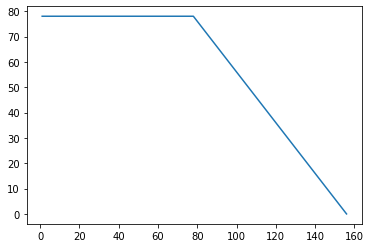

In [20]:
id = 98
unit = norm_train_df[norm_train_df['id']==id]
plt.plot(unit['cycle'],unit['RUL']);

In [12]:
import tsfresh

# Feature Extraciton
- Use of tsfresh
- Expanding Window transformation

In [109]:
# d = rul_hat-rul (predicted-real)
def scoring_function(d):
    """
    The scoring function S penalizes more an overestimation than an underestimation. 
    """
    if d < 0:
        s = np.exp(-d/13)-1
    elif d >= 0:
        s = np.exp(d/10)-1
    return s

In [16]:
scoring_function(-3)

0.2595685362456337